## CH05. MultiModal RAG

### 1. 이미지, 텍스트 멀티모달 : 차량 문서와 차량 이미지 멀티모달

In [ ]:
%pip install git+https://github.com/run-llama/llama_index.git
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch==2.2.2 torchvision==0.17.2
%pip install matplotlib scikit-image
%pip install -U qdrant_client
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index
%pip install python-dotenv
%pip install llama-index-embeddings-clip
%pip install llama-index-vector-stores-qdrant
%pip install -U llama-index-llms-openai
%pip install -U llama-index llama-index-core llama-index-multi-modal-llms-openai

In [18]:
# API Key 불러오기
from dotenv import load_dotenv
load_dotenv()

True

In [19]:
# 파일 경로 추가
import os
image_paths = []
for img_path in os.listdir("./data_image/cars"):
    image_paths.append(str(os.path.join("./data_image/cars", img_path)))
print(image_paths)

['./data_image/cars\\b1.txt', './data_image/cars\\car_img1.jpg', './data_image/cars\\car_img2.jpg', './data_image/cars\\car_img3.jpg', './data_image/cars\\car_img4.jpg', './data_image/cars\\car_img5.jpg', './data_image/cars\\car_img6.JPG', './data_image/cars\\h1.txt', './data_image/cars\\t1.txt']


In [20]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지를 출력하는 함수
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        img_path = img_path.lower() # 소문자화
        if ".jpg" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


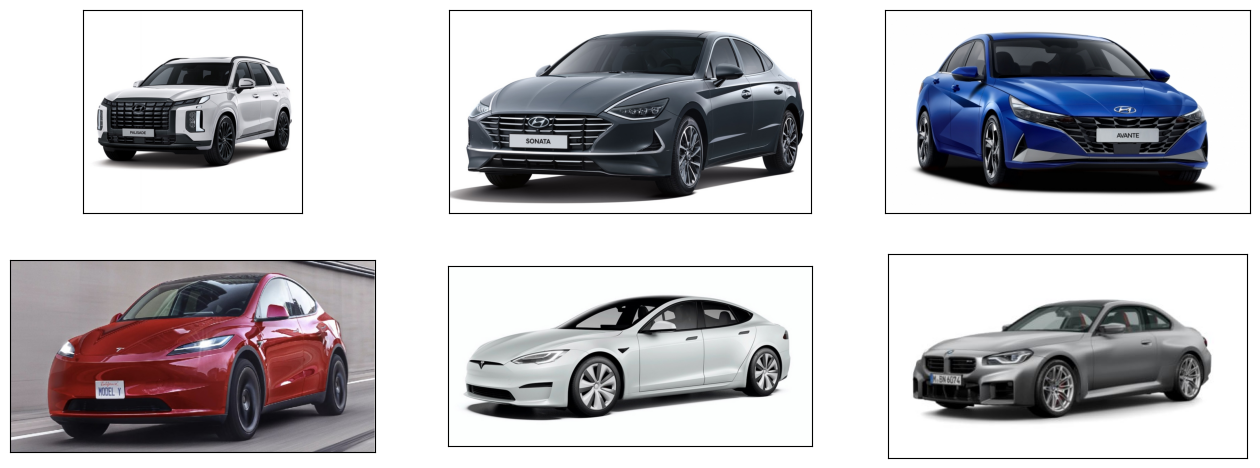

In [21]:
# 실행
plot_images(image_paths)

In [22]:
from llama_index.core import SimpleDirectoryReader
image_documents = SimpleDirectoryReader(input_dir="./data_image/cars", 
                                        required_exts=[".jpg"]).load_data()


In [24]:
image_documents[0]

ImageDocument(id_='81e115a7-7b9a-4d62-918f-8f1418b23860', embedding=None, metadata={'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\cars\\car_img1.jpg', 'file_name': 'car_img1.jpg', 'file_type': 'image/jpeg', 'file_size': 114194, 'creation_date': '2025-02-08', 'last_modified_date': '2025-02-08'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=None, image_resource=MediaResource(embeddings=None, data=None, text=None, path=WindowsPath('c:/Users/USER/OneDrive/Desktop/Project/llamaindex_practice/ch05/data_image/cars/car_img1.jpg'), url=None, mimetype='image/jpeg'), audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{c

### [참고사항]
llama-index (0.10.x ~ 0.11.x) 시절에 SimpleDirectoryReader가 이미지 파일을 읽으면 ImageDocument 객체를 돌려줬습니다.
**2024년 중반 이후 릴리즈(0.12.x core / 0.14.x 본체)**부터 멀티모달 데이터 모델이 대대적으로 업데이트되었음.

Document, ImageDocument 같은 단일 타입 대신
→ Node 계열 (TextNode, ImageNode, …) 로 통일 됨.

LLM 입력/출력 블록도 TextBlock, ImageBlock 기반으로 개편.
따라서 llama-index-core가 0.12.x로 올라가면서 ImageDocument는 deprecated / 제거되고,
ImageNode만 지원하게 됨

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
openai_mm_llm = OpenAIMultiModal(model="gpt-4o", 
                                 max_new_tokens=2000,)


C:\Users\USER\AppData\Local\Temp\ipykernel_2520\3837975595.py:2: DeprecationWarning: Call to deprecated class OpenAIMultiModal. (The package has been deprecated and will no longer be maintained. Please use llama-index-llms-openai (preferably the Responses API) instead. See Multi Modal LLMs documentation for a complete guide on migration: https://docs.llamaindex.ai/en/stable/understanding/using_llms/using_llms/#multi-modal-llms) -- Deprecated since version 0.5.2.
  openai_mm_llm = OpenAIMultiModal(model="gpt-4o",


In [ ]:
'''
위 업데이트 내용에 따라 아래 코드는 최신 라마인덱스 버전에서는 동작하지 않음
구버전에서는 image_documents로 동작하였으나 최신버전에서는 image_documents를 지원하지 않음.
'''
# response = openai_mm_llm.complete(
#     prompt="이미지에 있는 차량에 대해 색상 및 특징에 대해 묘사해주세요",
#     image_documents=image_documents
# )

'''
최신버전에서는 아래 코드와 같이 ImageNode로 변경하여 사용
(llama-index 0.14.2 기준)
'''
from llama_index.core.schema import ImageNode
image_nodes = [ImageNode(image_path=doc.metadata["file_path"]) 
               for doc in image_documents]
response = openai_mm_llm.complete(
    prompt="이미지에 있는 차량에 대해 색상 및 특징에 대해 묘사해주세요",
    image_documents=image_nodes
)
print(response)

2025-09-23 22:53:13,742 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


1. 첫 번째 차량은 흰색 SUV로, 대형 그릴과 세련된 헤드라이트 디자인이 특징입니다.

2. 두 번째 차량은 회색 세단으로, 날렵한 전면 디자인과 크롬 디테일이 돋보입니다.

3. 세 번째 차량은 파란색 세단으로, 독특한 전면 그릴과 날카로운 헤드라이트가 특징입니다.

4. 네 번째 차량은 빨간색 SUV로, 매끄러운 차체와 현대적인 디자인이 돋보입니다.

5. 다섯 번째 차량은 흰색 세단으로, 깔끔한 라인과 미니멀한 디자인이 특징입니다.


### 2. 라마인덱스 멀티모달 RAG 파이프라인(이미지, 텍스트)

In [28]:
# 파일 경로 추가
import os
image_paths = []
for img_path in os.listdir("./data_image/cars"):
    image_paths.append(str(os.path.join("./data_image/cars", img_path)))
print(image_paths)

['./data_image/cars\\b1.txt', './data_image/cars\\car_img1.jpg', './data_image/cars\\car_img2.jpg', './data_image/cars\\car_img3.jpg', './data_image/cars\\car_img4.jpg', './data_image/cars\\car_img5.jpg', './data_image/cars\\car_img6.JPG', './data_image/cars\\h1.txt', './data_image/cars\\t1.txt']


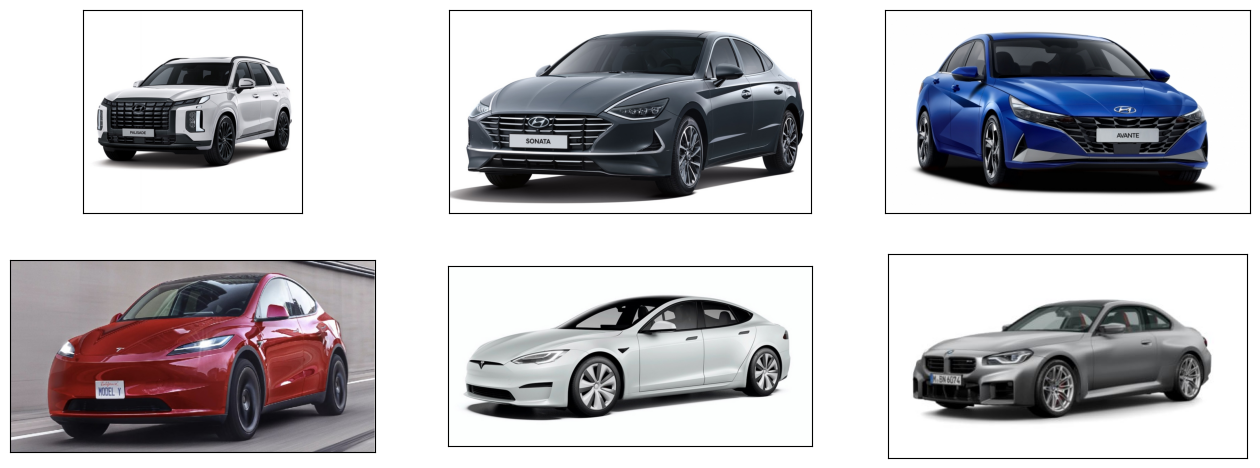

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
img_path_list = ['jpg','png','jfif']
plot_images(image_paths) # image 출력

In [30]:
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader('./data_image/cars').load_data()

# 읽어 온 문서 타입 출력
for doc in documents:
    print(doc.metadata)

{'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\cars\\b1.txt', 'file_name': 'b1.txt', 'file_type': 'text/plain', 'file_size': 1358, 'creation_date': '2025-03-03', 'last_modified_date': '2025-03-03'}
{'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\cars\\car_img1.jpg', 'file_name': 'car_img1.jpg', 'file_type': 'image/jpeg', 'file_size': 114194, 'creation_date': '2025-02-08', 'last_modified_date': '2025-02-08'}
{'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\cars\\car_img2.jpg', 'file_name': 'car_img2.jpg', 'file_type': 'image/jpeg', 'file_size': 176227, 'creation_date': '2025-02-08', 'last_modified_date': '2025-02-08'}
{'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\cars\\car_img3.jpg', 'file_name': 'car_img3.jpg', 'file_type': 'image/jpeg', 'file_size': 146852, 'creation_date': '2025-02

In [31]:
# 신규 생성 (기존 경로가 이미 존재 할 경우 불러옴)
from qdrant_client import QdrantClient
client = QdrantClient(path="./index/ch05_3_2_qdrant_db")

In [32]:
from llama_index.vector_stores.qdrant import QdrantVectorStore

# 텍스트에 대한 벡터 스토어 구성
text_store= QdrantVectorStore(client=client,
                              collection_name="text_collection")
# 이미지에 대한 벡터 스토어 구성
image_store = QdrantVectorStore(client=client, 
                              collection_name="image_collection")

# stroage context를 통해 멀티모달 벡터 스토어 및 인덱스를 통합관리
from llama_index.core import StorageContext
storage_context = StorageContext.from_defaults(
    vector_store=text_store,
    image_store=image_store
)

### MultiModalVectorStoreIndex 참고사항
1. embed_model 미지정시 Settings 설정값이 자동 적용 됨
2. image_embed_model은 clip 모델이 기본값으로 적용되므로 clip 사전 설치 필요함
3. numpy 2.x 버전에 실행이 안됨. 1.24.0으로 다운그레이드 후 사용할것(25년6월)

In [33]:
# 멀티 모달 인덱스 구성 및 저장
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
index = MultiModalVectorStoreIndex.from_documents(
    documents=documents,
    storage_context=storage_context,
)
index.storage_context.persist(persist_dir="./index/ch05_3_2_qdrant_db")

c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-23 22:49:01,525 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [38]:
# 저장된 StorageContext 로드
from llama_index.core import load_index_from_storage
storage_context = StorageContext.from_defaults(
    persist_dir="./index/ch05_3_2_qdrant_db",
    vector_store=text_store,
    image_store=image_store
)

# 저장된 인덱스 로드
index = load_index_from_storage(storage_context)

2025-09-23 22:53:30,076 - INFO - Loading all indices.


Loading llama_index.core.storage.kvstore.simple_kvstore from ./index/ch05_3_2_qdrant_db\docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./index/ch05_3_2_qdrant_db\index_store.json.


In [39]:
retriever_engine = index.as_retriever(
    similarity_top_k = 3,
    image_similarity_top_k = 3
)

In [40]:
retrieval_results = retriever_engine.retrieve("현대자동차를 찾아주세요")

2025-09-23 22:53:49,113 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


**Node ID:** ca16c91d-ff4f-4c09-a7d8-d33837b74d2c<br>**Similarity:** 0.8702926365117065<br>**Text:** ​현대자동차는 1967년 설립된 대한민국의 대표적인 자동차 제조사로, 글로벌 시장에서 다양한 승용차, 상용차, 전기차 등을 생산·판매하고 있습니다. 현대자동차그룹의 일원으로서, 기아, 제네시스, 아이오닉 등의 브랜드를 보유하고 있으며, 전 세계 200여 개국에서 차량을 판매하고 있습니다. 특히, 울산에 위치한 연간 160만 대 생산 능력을 갖춘 공장은...<br>

**Node ID:** 6b979c6e-4c4f-4b2b-931f-7cfb62fc22df<br>**Similarity:** 0.8464433903681785<br>**Text:** ​
글로벌 CEO 임명: 2024년 11월, 현대자동차는 글로벌 최고운영책임자(COO)인 호세 무뇨스를 2025년 1월 1일부터 글로벌 공동 CEO로 임명한다고 발표했습니다. 무뇨스는 북미 지역에서의 성공적인 실적을 바탕으로 승진하게 되었습니다. ​

제네시스 G90 블랙 출시: 2024년 6월, 현대자동차의 고급 브랜드인 제네시스는 '제네시스 ...<br>

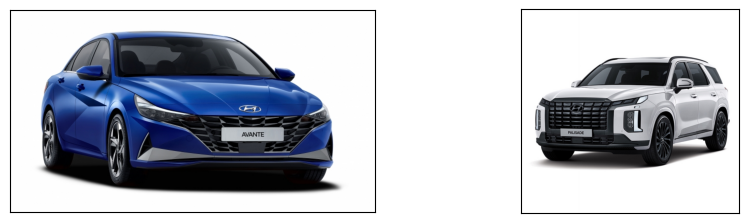

In [41]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode): # 이미지 노드일 경우
        retrieved_image.append(res_node.node.metadata["file_path"]) # image file path 저장
    else: # 텍스트 노드일 경우
        display_source_node(res_node, source_length=200)
retrieved_image
plot_images(retrieved_image) # 이미지 노드 plot

In [42]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
openai_mm_llm = OpenAIMultiModal(model="gpt-4o", 
                                 max_new_tokens=2000,)

C:\Users\USER\AppData\Local\Temp\ipykernel_2520\3837975595.py:2: DeprecationWarning: Call to deprecated class OpenAIMultiModal. (The package has been deprecated and will no longer be maintained. Please use llama-index-llms-openai (preferably the Responses API) instead. See Multi Modal LLMs documentation for a complete guide on migration: https://docs.llamaindex.ai/en/stable/understanding/using_llms/using_llms/#multi-modal-llms) -- Deprecated since version 0.5.2.
  openai_mm_llm = OpenAIMultiModal(model="gpt-4o",


In [43]:
query_engine = index.as_query_engine(
    llm=openai_mm_llm,
    similarity_top_k =1,
    image_similarity_top_k = 1
)

In [44]:
from llama_index.core import PromptTemplate
# 프롬프트 템플릿 정의
template = (
    "제공 된 사진을 참고하여 한국어로 답변을 해주세요.\n"
    "{query_str}\n"
)
prompt_template = PromptTemplate(template)


2025-09-23 22:54:13,041 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-09-23 22:54:20,183 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Prompt :  현대 SUV 모델과 제조사 설명
Response :
사진은 현대자동차의 SUV 모델인 팰리세이드입니다. 현대자동차는 1967년에 설립된 대한민국의 대표적인 자동차 제조사로, 다양한 승용차, 상용차, 전기차 등을 생산·판매하고 있습니다. 현대자동차그룹의 일원으로서 기아, 제네시스, 아이오닉 등의 브랜드를 보유하고 있으며, 전 세계 200여 개국에서 차량을 판매하고 있습니다. 현대자동차는 '휴머니티를 향한 진보'라는 비전 아래, 로보틱스, 미래 모빌리티, 수소 에너지 등 다양한 분야로 사업을 확장하고 있습니다.


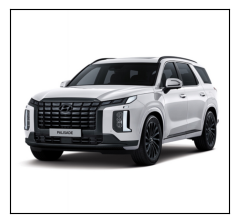

In [45]:
query_str = "현대 SUV 모델과 제조사 설명"
final_prompt = prompt_template.format(query_str=query_str)
response = query_engine.query(final_prompt)

# prompt와 response 출력
print("Prompt : ", query_str)
print(f'Response :\n{response}')
# image 출력
retrieved_img=[]
for k, v in response.metadata.items():
    if k == 'image_nodes': # 이미지 노드인 경우
        img_path = v[0].metadata['file_path'] # 첫번째 요소의 파일 경로
        retrieved_img.append(img_path)
plot_images(retrieved_img)
        

In [46]:
for k, v in response.metadata.items():
    for one in v:
        print(k, one.metadata)

text_nodes {'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\cars\\h1.txt', 'file_name': 'h1.txt', 'file_type': 'text/plain', 'file_size': 2367, 'creation_date': '2025-03-03', 'last_modified_date': '2025-03-03'}
image_nodes {'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\cars\\car_img1.jpg', 'file_name': 'car_img1.jpg', 'file_type': 'image/jpeg', 'file_size': 114194, 'creation_date': '2025-02-08', 'last_modified_date': '2025-02-08'}
